<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-и-загрузка-данных" data-toc-modified-id="Подготовка-и-загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка и загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Приведение-столбца-к-формату-datetime" data-toc-modified-id="Приведение-столбца-к-формату-datetime-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Приведение столбца к формату datetime</a></span></li><li><span><a href="#Перемещение-столбца-в-индекс" data-toc-modified-id="Перемещение-столбца-в-индекс-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Перемещение столбца в индекс</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Дерево-регрессии" data-toc-modified-id="Дерево-регрессии-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево регрессии</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Анализ</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка и загрузка данных

Загрузим необходимые библиотеки

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q
!pip install optuna -q
!pip install lightgbm -q

Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
import optuna
import lightgbm as lgb
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from lightgbm import early_stopping
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('F:\\Учеба яндекс\\projects\\11_taxi\\taxi.csv')

### Подготовка

In [4]:
def first_look(df):
    df.info()
    return display(df.describe(),'Первые 5 строк', df.head(5), 'Последние 5 строк', df.tail(5))

Выполним первоначальный осмотр данных

In [5]:
first_look(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


'Первые 5 строк'

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


'Последние 5 строк'

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


Видно, что пропусков в данных нет, требуется замена числового индекса столбцом с датой, приведение столбца к формату datetime.

#### Приведение столбца к формату datetime

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'])

#### Перемещение столбца в индекс

In [7]:
data.sort_values(by = 'datetime', inplace = True)
data.set_index('datetime', inplace = True)

#### Ресемплирование

In [8]:
data = data.resample('1H').sum()

**Вывод:** выполнена загрузка данных, знакомство с ними, столбец с информацией о дате приведен к формату datetime, а также переведен в индекс, выполнено ресемплирование по часу с суммированием количества заказов. Данные достаточно чистые, пропусков нет.

## Анализ

Построим график количества поездок **без применения инструментов анализа**.

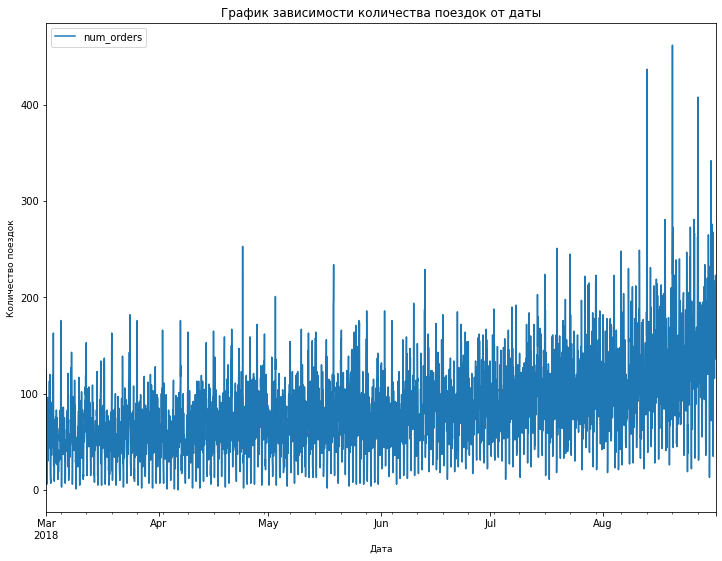

In [9]:
data.plot(kind = 'line', figsize = (12,9))

plt.title('График зависимости количества поездок от даты', size = 12)
plt.xlabel('Дата', size = 9)
plt.ylabel('Количество поездок', size = 9)

plt.show()

Из такого графика сложно уловить наличие зависимостей. Необходимо воспользоваться инструментами для анализа временных рядов.

Для прослеживания зависимостей необходимо найти суточное скользящее среднее, недельный тренд, а также разложим данные на сезонные состовляющие.

In [10]:
decomposed = seasonal_decompose(data)

Построим график количества заказов в сутки, недельное скользящее среднее, а также месячный тренд.

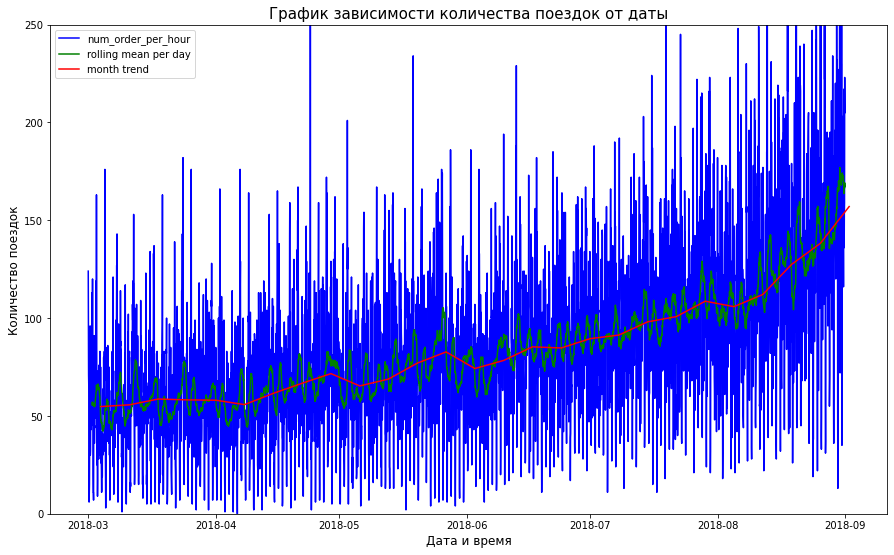

In [11]:
plt.figure(figsize = (15,9))

plt.plot(data, color = 'b', label = 'num_order_per_hour')
plt.plot(data.rolling(24).mean(), color = 'g', label = 'rolling mean per day')
plt.plot(decomposed.trend.resample('1w').mean(), color = 'r', label = 'month trend')

plt.title('График зависимости количества поездок от даты', size = 15)
plt.xlabel('Дата и время', size = 12)
plt.ylabel('Количество поездок', size = 12)

plt.ylim(0,250)

plt.legend()
plt.show()

Из проведенного анализа четко видно увеличение количетсва поездок в день, намечена тенденция на увеличение загруженности водителей.

Для дополнительного анализа выведем сезонную составляющую.

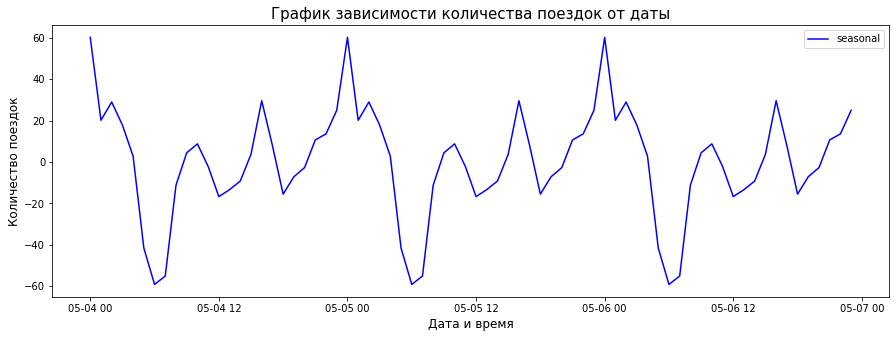

In [12]:
plt.figure(figsize = (15,5))
plt.plot(decomposed.seasonal['2018-05-04':'2018-05-06'], color = 'b', label = 'seasonal')
plt.title('График зависимости количества поездок от даты', size = 15)
plt.xlabel('Дата и время', size = 12)
plt.ylabel('Количество поездок', size = 12)

plt.legend()
plt.show()

Из приведенного графика видно, что сезонным периодом явялется один день.

Дополнительно проанализируем число заказов по дням недели, месяца, а также часам суток.

In [13]:
data_for_analize = data.copy()
data_for_analize['dayofweek'] = data_for_analize.index.dayofweek
data_for_analize['hour'] = data_for_analize.index.hour
data_for_analize['day'] = data_for_analize.index.day

**День недели**

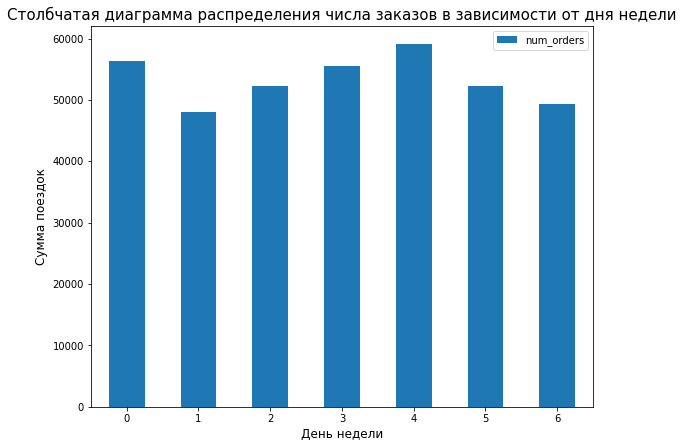

In [14]:
plt.figure(figsize = (9,7))
data_for_analize.groupby('dayofweek')['num_orders'].sum().plot( kind = 'bar')

plt.title('Столбчатая диаграмма распределения числа заказов в зависимости от дня недели', size = 15)
plt.xlabel('День недели', size = 12)
plt.xticks(rotation=0)
plt.ylabel('Сумма поездок', size = 12)

plt.legend()
plt.show()

**День месяца**

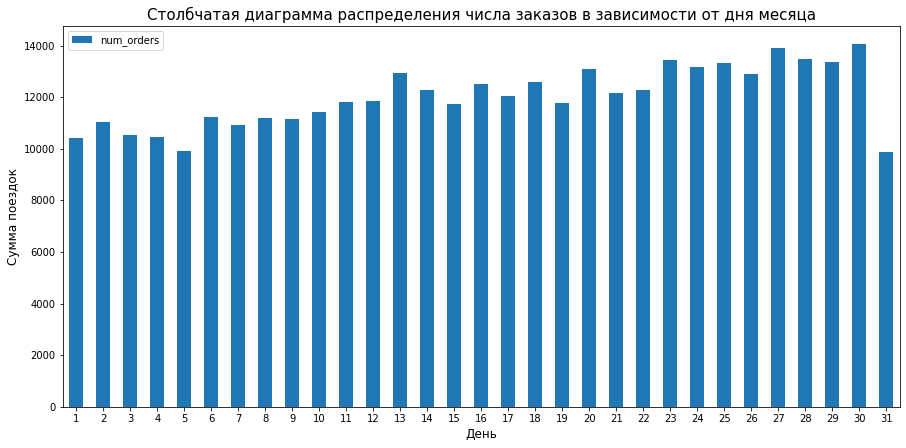

In [15]:
plt.figure(figsize = (15,7))
data_for_analize.groupby('day')['num_orders'].sum().plot( kind = 'bar')

plt.title('Столбчатая диаграмма распределения числа заказов в зависимости от дня месяца', size = 15)
plt.xlabel('День', size = 12)
plt.xticks(rotation=0)
plt.ylabel('Сумма поездок', size = 12)

plt.legend()
plt.show()

**Час**

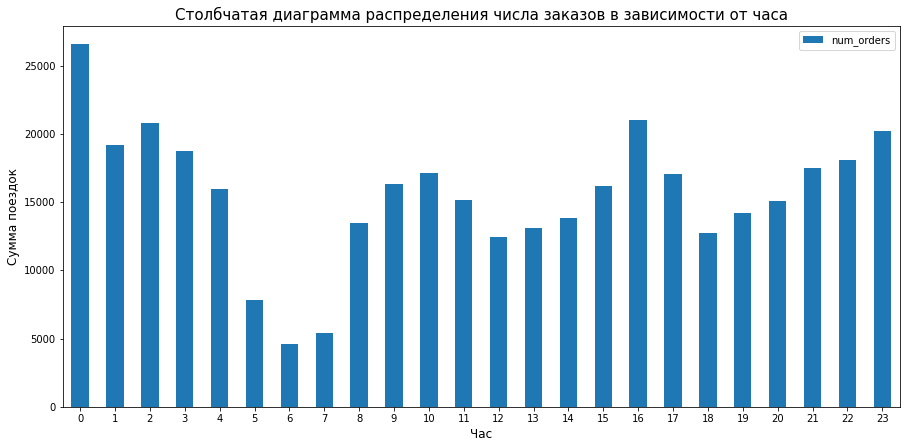

In [16]:
plt.figure(figsize = (15,7))
data_for_analize.groupby('hour')['num_orders'].sum().plot( kind = 'bar')

plt.title('Столбчатая диаграмма распределения числа заказов в зависимости от часа', size = 15)
plt.xlabel('Час', size = 12)
plt.xticks(rotation=0)
plt.ylabel('Сумма поездок', size = 12)

plt.legend()
plt.show()

Построенные графики позволяют заметить, что самым полезным признаком может послужить час заказа такси, при этом минимальное количество заказов приходится на 6 часов утра, максимальное число приходится на 0 часов. Дополнительно стоит отметить, что число заказов растет от начала к концу месяца, максимально в пятницу, минимально во вторник.

**Вывод:** проведен анализ данных в ходе которого установлено, что количество поездок в день немонотонно, однако же в среднем, оно растет, что подтверждает тренд. Сезонный промежуток равен дню при семплировании данных по часу. Минимальное количество заказов приходится на 6 часов утра, максимальное - на 0 часов. Дополнительно стоит отметить, что число заказов растет от начала к концу месяца, максимально в пятницу, минимально во вторник.

## Обучение

Создадим дополнительные признаки, которые помогут улучшить предсказание модели.

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    
    for i in range(1, max_lag + 1):
        df[f'lag_{i}'] = df['num_orders'].shift(i)

    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()

Закрепим необходимые константы

In [18]:
RANDOM_STATE = 42

Руководствуясь результатами, полученными при выполнении анализа данных, сформируем признаки исходя из дневной сезонности количества поездок в день.

### Градиентный бустинг

In [19]:
def lgbm_objective(trial):
    
    data_study = data.copy()
    
    features = {
        'df': data_study,
                
        # параметры для making_features
        'max_lag': trial.suggest_int('max_lag', 6, 24),
        'rolling_mean_size': trial.suggest_int('rolling_mean_size', 1, 12)
    }
    
    make_features(**features)
    
    X_train,X_test,y_train,y_test = train_test_split(
        data_study.drop('num_orders', axis = 1),
        data_study['num_orders'],
        test_size = 0.1,
        random_state = RANDOM_STATE,
        shuffle = False)
    
    X_train,X_valid,y_train,y_valid = train_test_split(
        X_train,
        y_train,
        test_size = 0.1,
        random_state = RANDOM_STATE,
        shuffle = False)
    
    params = {
        'objective': 'regression',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_STATE,
        'n_estimators': 10000,
        
        # параметры, которые будем отбирать для GB
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 50),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0)
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[early_stopping(stopping_rounds=100)]
        
    )
    
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred, squared=False)
    return mse

In [20]:
study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

study.optimize(lgbm_objective, n_trials=25)

[I 2025-06-11 17:35:55,630] A new study created in memory with name: no-name-52d37c48-b1a2-4a5e-b9bd-b5a4a4125533


Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:35:56,743] Trial 0 finished with value: 31.042565003451422 and parameters: {'max_lag': 13, 'rolling_mean_size': 12, 'learning_rate': 0.22227824312530747, 'num_leaves': 62, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.4348501673009197, 'colsample_bytree': 0.9197056874649611}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[116]	valid_0's rmse: 31.0426	valid_0's l2: 963.641
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[473]	valid_0's rmse: 31.6362	valid_0's l2: 1000.85


[I 2025-06-11 17:36:09,855] Trial 1 finished with value: 31.636203696015865 and parameters: {'max_lag': 17, 'rolling_mean_size': 9, 'learning_rate': 0.01596950334578271, 'num_leaves': 98, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.5090949803242604, 'colsample_bytree': 0.5100427059120604}. Best is trial 0 with value: 31.042565003451422.


Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:11,438] Trial 2 finished with value: 32.5642863428894 and parameters: {'max_lag': 11, 'rolling_mean_size': 7, 'learning_rate': 0.13526405540621358, 'num_leaves': 32, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.5752867891211308, 'colsample_bytree': 0.619817105976215}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[61]	valid_0's rmse: 32.5643	valid_0's l2: 1060.43
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:15,339] Trial 3 finished with value: 31.627298395678164 and parameters: {'max_lag': 14, 'rolling_mean_size': 10, 'learning_rate': 0.06790539682592432, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.764526911140863, 'colsample_bytree': 0.502314474212375}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[178]	valid_0's rmse: 31.6273	valid_0's l2: 1000.29
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:16,346] Trial 4 finished with value: 32.54242028067293 and parameters: {'max_lag': 7, 'rolling_mean_size': 12, 'learning_rate': 0.2900332895916222, 'num_leaves': 82, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8105398159072941, 'colsample_bytree': 0.6640914962437607}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[47]	valid_0's rmse: 32.5424	valid_0's l2: 1059.01
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[882]	valid_0's rmse: 33.1827	valid_0's l2: 1101.09


[I 2025-06-11 17:36:22,741] Trial 5 finished with value: 33.1826895373271 and parameters: {'max_lag': 8, 'rolling_mean_size': 6, 'learning_rate': 0.019972671123413333, 'num_leaves': 92, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.5870266456536466, 'colsample_bytree': 0.7120408127066865}. Best is trial 0 with value: 31.042565003451422.


Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:24,537] Trial 6 finished with value: 32.97028012602303 and parameters: {'max_lag': 16, 'rolling_mean_size': 3, 'learning_rate': 0.291179542051722, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.7587399872866512, 'colsample_bytree': 0.9531245410138701}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[16]	valid_0's rmse: 32.9703	valid_0's l2: 1087.04
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	valid_0's rmse: 33.4411	valid_0's l2: 1118.31


[I 2025-06-11 17:36:29,051] Trial 7 finished with value: 33.44111662336869 and parameters: {'max_lag': 7, 'rolling_mean_size': 3, 'learning_rate': 0.023115913784056037, 'num_leaves': 36, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.8972425054911576, 'colsample_bytree': 0.6140519960161536}. Best is trial 0 with value: 31.042565003451422.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1043]	valid_0's rmse: 31.6425	valid_0's l2: 1001.24


[I 2025-06-11 17:36:32,153] Trial 8 finished with value: 31.64245454590528 and parameters: {'max_lag': 11, 'rolling_mean_size': 7, 'learning_rate': 0.050868025242681164, 'num_leaves': 82, 'max_depth': 3, 'min_child_samples': 50, 'subsample': 0.8633468615779945, 'colsample_bytree': 0.5192294089205034}. Best is trial 0 with value: 31.042565003451422.


Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:34,339] Trial 9 finished with value: 34.18028946828302 and parameters: {'max_lag': 6, 'rolling_mean_size': 10, 'learning_rate': 0.21498862971580895, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.6150794371265635, 'colsample_bytree': 0.4695214357150779}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[28]	valid_0's rmse: 34.1803	valid_0's l2: 1168.29
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:35,438] Trial 10 finished with value: 31.652661076180344 and parameters: {'max_lag': 23, 'rolling_mean_size': 12, 'learning_rate': 0.20028437880848377, 'num_leaves': 6, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.40908654226165414, 'colsample_bytree': 0.9856839399147971}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[180]	valid_0's rmse: 31.6527	valid_0's l2: 1001.89
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:37,339] Trial 11 finished with value: 31.186026892794377 and parameters: {'max_lag': 13, 'rolling_mean_size': 10, 'learning_rate': 0.11221980634745266, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.9693641950661773, 'colsample_bytree': 0.8468500116346949}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[83]	valid_0's rmse: 31.186	valid_0's l2: 972.568
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:38,951] Trial 12 finished with value: 31.12207126658591 and parameters: {'max_lag': 20, 'rolling_mean_size': 12, 'learning_rate': 0.12633373867857195, 'num_leaves': 57, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9968331616162444, 'colsample_bytree': 0.8475971801379842}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[104]	valid_0's rmse: 31.1221	valid_0's l2: 968.583
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:40,047] Trial 13 finished with value: 31.673541690850993 and parameters: {'max_lag': 20, 'rolling_mean_size': 12, 'learning_rate': 0.18030196160665224, 'num_leaves': 39, 'max_depth': 4, 'min_child_samples': 33, 'subsample': 0.9996174631849308, 'colsample_bytree': 0.8311518451315368}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[88]	valid_0's rmse: 31.6735	valid_0's l2: 1003.21
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:41,538] Trial 14 finished with value: 31.883239774916245 and parameters: {'max_lag': 21, 'rolling_mean_size': 5, 'learning_rate': 0.24141851203291492, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.6772688550406769, 'colsample_bytree': 0.8555610625614984}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[68]	valid_0's rmse: 31.8832	valid_0's l2: 1016.54
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:43,343] Trial 15 finished with value: 31.22834416508808 and parameters: {'max_lag': 18, 'rolling_mean_size': 1, 'learning_rate': 0.10643467279584748, 'num_leaves': 43, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.41241881162228133, 'colsample_bytree': 0.7634222449905999}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[246]	valid_0's rmse: 31.2283	valid_0's l2: 975.209
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:44,744] Trial 16 finished with value: 32.02034105072117 and parameters: {'max_lag': 19, 'rolling_mean_size': 9, 'learning_rate': 0.2510435295785099, 'num_leaves': 62, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.6824634788258586, 'colsample_bytree': 0.9271825820808323}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[22]	valid_0's rmse: 32.0203	valid_0's l2: 1025.3
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:46,246] Trial 17 finished with value: 31.596471595243486 and parameters: {'max_lag': 24, 'rolling_mean_size': 11, 'learning_rate': 0.15913694741493067, 'num_leaves': 21, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.5025829736912527, 'colsample_bytree': 0.9033159542100373}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[130]	valid_0's rmse: 31.5965	valid_0's l2: 998.337
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:47,654] Trial 18 finished with value: 31.94525831641935 and parameters: {'max_lag': 11, 'rolling_mean_size': 8, 'learning_rate': 0.15587194580738042, 'num_leaves': 47, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.9083847228527203, 'colsample_bytree': 0.775866043088393}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[283]	valid_0's rmse: 31.9453	valid_0's l2: 1020.5
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:48,739] Trial 19 finished with value: 32.312449122637545 and parameters: {'max_lag': 22, 'rolling_mean_size': 12, 'learning_rate': 0.24298024096928925, 'num_leaves': 68, 'max_depth': 5, 'min_child_samples': 38, 'subsample': 0.4664340477865215, 'colsample_bytree': 0.8894379023857256}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[29]	valid_0's rmse: 32.3124	valid_0's l2: 1044.09
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:52,545] Trial 20 finished with value: 31.525715135818675 and parameters: {'max_lag': 15, 'rolling_mean_size': 11, 'learning_rate': 0.09937620155375605, 'num_leaves': 24, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7526490584295522, 'colsample_bytree': 0.7811210518056801}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[270]	valid_0's rmse: 31.5257	valid_0's l2: 993.871
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:53,943] Trial 21 finished with value: 31.302951904419185 and parameters: {'max_lag': 13, 'rolling_mean_size': 10, 'learning_rate': 0.12078258565855271, 'num_leaves': 56, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.999531399924316, 'colsample_bytree': 0.833146632701707}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[57]	valid_0's rmse: 31.303	valid_0's l2: 979.875
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:56,638] Trial 22 finished with value: 31.822804290530776 and parameters: {'max_lag': 12, 'rolling_mean_size': 11, 'learning_rate': 0.07535377477592328, 'num_leaves': 52, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.9244909845052713, 'colsample_bytree': 0.9882433727919857}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[116]	valid_0's rmse: 31.8228	valid_0's l2: 1012.69
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:36:58,938] Trial 23 finished with value: 32.39955917519814 and parameters: {'max_lag': 9, 'rolling_mean_size': 9, 'learning_rate': 0.1344779068268377, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.9597980300318104, 'colsample_bytree': 0.8716384195014207}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[60]	valid_0's rmse: 32.3996	valid_0's l2: 1049.73
Training until validation scores don't improve for 100 rounds


[I 2025-06-11 17:37:00,140] Trial 24 finished with value: 32.44181435498629 and parameters: {'max_lag': 15, 'rolling_mean_size': 11, 'learning_rate': 0.17749917026697076, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.8428971241275693, 'colsample_bytree': 0.8052783677914537}. Best is trial 0 with value: 31.042565003451422.


Early stopping, best iteration is:
[124]	valid_0's rmse: 32.4418	valid_0's l2: 1052.47


Наименьшее достигнутое значение RMSE на валидационной выборке составило:

In [21]:
lgbm_rmse = round(study.best_value, 2)
lgbm_rmse

31.04

При этом параметры модели следующие:

In [22]:
best_params = study.best_params
best_params

{'max_lag': 13,
 'rolling_mean_size': 12,
 'learning_rate': 0.22227824312530747,
 'num_leaves': 62,
 'max_depth': 4,
 'min_child_samples': 9,
 'subsample': 0.4348501673009197,
 'colsample_bytree': 0.9197056874649611}

### Дерево регрессии

In [23]:
def reg_tree_objective(trial):
    
    data_study = data.copy()
    
    features = {
        'df': data_study,
                
        # параметры для making_features
        'max_lag': trial.suggest_int('max_lag', 6, 24),
        'rolling_mean_size': trial.suggest_int('rolling_mean_size', 1, 12)
    }
    
    make_features(**features)
    data_study.dropna(inplace = True)
    
    X_train,X_test,y_train,y_test = train_test_split(
        data_study.drop('num_orders', axis = 1),
        data_study['num_orders'],
        test_size = 0.1,
        random_state = RANDOM_STATE,
        shuffle = False)
    
    X_train,X_valid,y_train,y_valid = train_test_split(
        X_train,
        y_train,
        test_size = 0.1,
        random_state = RANDOM_STATE,
        shuffle = False)
    
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)
    
    regressor = DecisionTreeRegressor(max_depth = max_depth,
                                      min_samples_split = min_samples_split,
                                      min_samples_leaf = min_samples_leaf,
                                      random_state = RANDOM_STATE)
    
    regressor.fit(
        X_train, y_train        
    )
    
    y_pred = regressor.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred, squared=False)
    return mse

In [24]:
tree_study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

tree_study.optimize(reg_tree_objective, n_trials=25)

[I 2025-06-11 17:37:00,223] A new study created in memory with name: no-name-ad4998e3-d04a-4cd4-a540-6c7929a19175
[I 2025-06-11 17:37:00,296] Trial 0 finished with value: 35.21123546054154 and parameters: {'max_lag': 13, 'rolling_mean_size': 12, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 5}. Best is trial 0 with value: 35.21123546054154.
[I 2025-06-11 17:37:00,347] Trial 1 finished with value: 40.29794993383951 and parameters: {'max_lag': 8, 'rolling_mean_size': 1, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: 35.21123546054154.
[I 2025-06-11 17:37:00,391] Trial 2 finished with value: 36.64924561231736 and parameters: {'max_lag': 6, 'rolling_mean_size': 12, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 0 with value: 35.21123546054154.
[I 2025-06-11 17:37:00,441] Trial 3 finished with value: 37.97320050303065 and parameters: {'max_lag': 9, 'rolling_mean_size': 4, 'max_depth': 10, 'min_sa

Наименьшее достигнутое значение RMSE на валидационной выборке составило:

In [25]:
tree_rmse = round(tree_study.best_value, 2)
tree_rmse

34.02

При этом параметры модели следующие:

In [26]:
best_tree_params = tree_study.best_params
best_tree_params

{'max_lag': 15,
 'rolling_mean_size': 10,
 'max_depth': 13,
 'min_samples_split': 18,
 'min_samples_leaf': 8}

### Анализ

In [27]:
results = pd.DataFrame(data = {'lgbm': [lgbm_rmse],
                             'tree':[tree_rmse]},
                      index = ['rmse_val'])
results['%diff'] = round(abs((results['lgbm'] - results['tree'])/results['lgbm'] * 100),2)
results

,lgbm,tree,%diff
rmse_val,31.04,34.02,9.6


Поскольку заказчиком не были озвучены требования по времени обучения и предсказания модели, стоит выбрать наиболее точную, а именно, модель градиентного бустинга

In [28]:
best_params

{'max_lag': 13,
 'rolling_mean_size': 12,
 'learning_rate': 0.22227824312530747,
 'num_leaves': 62,
 'max_depth': 4,
 'min_child_samples': 9,
 'subsample': 0.4348501673009197,
 'colsample_bytree': 0.9197056874649611}

**Вывод:**  Наименьшее значение RMSE на валидационной выборке 31.04 достигнуто моделью градиентного бустинга. Параметры для формирования новых признаков: 'max_lag': 13, 'rolling_mean_size': 12. Гиперпараметры модели: 'learning_rate': 0.22, 'num_leaves': 62,  'max_depth': 4,  'min_child_samples': 9, 'subsample': 0.43, 'colsample_bytree': 0.92.
Поскольку заказчиком не были озвучены требования по времени обучения и предсказания модели, стоит выбрать наиболее точную, а именно, модель градиентного бустинга.

## Тестирование

In [29]:
make_features(data, best_params['max_lag'], best_params['rolling_mean_size'])
X_train,X_test,y_train,y_test = train_test_split(
    data.drop('num_orders', axis = 1),
    data['num_orders'],
    test_size = 0.1,
    random_state = RANDOM_STATE,
    shuffle = False)

Обучиим модель градиентного бустинга с оптимальными гиперпараметрами.

In [30]:
lgbm_reg = lgb.LGBMRegressor(objective = 'regression',
                         verbosity = -1,
                         boosting_type = 'gbdt',
                         random_state = RANDOM_STATE,
                         n_estimators = 10000,
                        
                        learning_rate = best_params['learning_rate'],
                        num_leaves = best_params['num_leaves'],
                        max_depth = best_params['max_depth'],
                        min_child_samples = best_params['min_child_samples'],
                        subsample = best_params['subsample'],
                        colsample_bytree = best_params['colsample_bytree'])

In [31]:
lgbm_reg.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9197056874649611,
              learning_rate=0.22227824312530747, max_depth=4,
              min_child_samples=9, n_estimators=10000, num_leaves=62,
              objective='regression', random_state=42,
              subsample=0.4348501673009197, verbosity=-1)

Вычислим значение RMSE на тестовой выборке:

In [32]:
round(mean_squared_error(y_test, lgbm_reg.predict(X_test), squared = False), 2)

44.54

**Вывод:** проведено тестирование разработанной модели: RMSE на тестовых данных равно 44.54, что удовлетворяет условию RMSE < 48. Модель пригодня для использования бизнесом.

## Вывод

Был проведен исследовательский анализ данных заказов такси из аэропорта сервиса «Чётенькое такси».

**В первой части работы** была выполнена загрузка и предобработка данных при которой столбец с информацией о дате приведен к формату datetime, переведен в индекс, выполнено ресемплирование по часу с суммированием количества заказов. Данные чистые, пропуски отсутствуют.

**Во второй части работы** был проведен анализ данных, в ходе которого построены графики суточной потребности в такси, дневной скользящей средней, а также размечен месячный тренд. 

**В третьей части** проведено обучение модели градиентного бустинга и дерева решений посредством модуля поиска гиперпараметров optuna. Наименьшее значение RMSE на валидационной выборке 31.95 достигнуто моделью градиентного бустинга. Параметры для формирования новых признаков: 'max_lag': 24, 'rolling_mean_size': 5. Гиперпараметры модели: 'learning_rate': 0.17, 'num_leaves': 5, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 1, 'colsample_bytree': 0.81.

**В четвертой части** проведено тестирование полученной модели, которое показало, что она удовлетворяет условию заказчика: RMSE на тестовых данных < 48 c результатом: 44.54.